<h1> Linear Regression </h1>
<p> Linear regression gives us a linear model $y$ based on our datapoints $x$, with a line of best fit. 
</p>
<p> In one dimension it looks like this </p>
$$
y = mx + c
$$
<p> It's basically just a line-fitting algorithm. Can scale to arbitrary dimensions. </p>

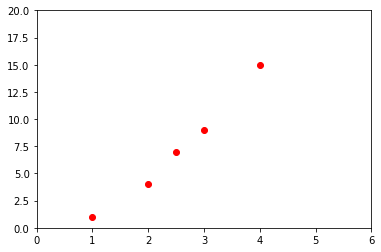

In [2]:
import numpy as np
from matplotlib import pyplot as plt

x = [1,2,2.5,3,4]
y = [1,4,7,9,15]
plt.plot(x,y,'ro')
plt.axis([0,6,0,20])
plt.show()

<p> Here x has a linear relationship with y (as x increases, so does y.) </p>

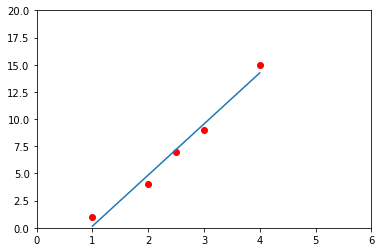

In [3]:
plt.plot(x,y,'ro')
plt.axis([0,6,0,20])
plt.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x)))
plt.show()

<h2> Making a linear model with TensorFlow </h2>


<p> Investigating the dataset of survival rates from the titanic (OK tensorflow website, that's a bit morbid...) </p>

In [10]:
!pip install -q sklearn
!pip install -q tensorflow
!pip install -q pandas

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

In [17]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [18]:
y_eval

0      0
1      0
2      1
3      1
4      1
      ..
259    1
260    0
261    0
262    0
263    1
Name: survived, Length: 264, dtype: int64

In [19]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [20]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [22]:
dftrain.shape

(627, 9)

Text(0.5, 0, 'Age (Years)')

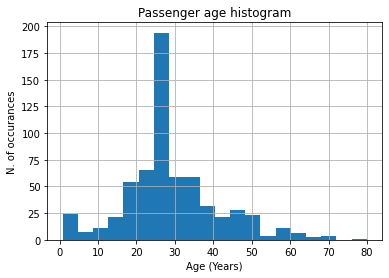

In [24]:
dftrain.age.hist(bins=20)
plt.title("Passenger age histogram")
plt.ylabel("N. of occurances")
plt.xlabel("Age (Years)")

<p> So most people are in their mid 20's. </p>

<p> Note: Categorical data is <em>NOT</em> numerical. I.e handedness: lefthanded/ righthanded </p>
<p> Usually represent categorical data by encoding them as integers. </p>
<p> Creating a list of features that we can categorize our dataset by: </p>

In [26]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

<p> Make an "input function" to convert the pandas dataframe into a
tf.data.Dataset object so that tensorflow can operate on it. </p>

In [30]:
def make_input_fn(data_df, label_df, num_epochs=15, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [31]:
#now creating the estimator model
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rf/q21h0s5d18j5rw4wyg_lh5x00000gn/T/tmpph8pctiv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [33]:
#training the model
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

#clear console output
clear_output()
#show accuracy of our model as a decimal (0.0-1.0)
print(result['accuracy'])

0.780303


In [35]:
#show model statistics
print(result)

{'accuracy': 0.780303, 'accuracy_baseline': 0.625, 'auc': 0.83618, 'auc_precision_recall': 0.7918551, 'average_loss': 0.46778336, 'label/mean': 0.375, 'loss': 0.45562118, 'precision': 0.72043014, 'prediction/mean': 0.37076408, 'recall': 0.67676765, 'global_step': 600}


In [47]:
#model predictions for a given passenger in the evaluation dataset
result = list(linear_est.predict(eval_input_fn))
clear_output()
print(dfeval.loc[2])
if y_eval.loc[3]:
    print("survived")
else:
    print("passed away")
print(result[0]['probabilities'][1])

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
survived
0.061827682


<p> Gives 6% percent survival probability for an older lady. But actually, she survived! (Nice, although this means our model got this one wrong.)</p>